In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

from modules.linear import *
from modules.loss import *
from modules.activation import *
from modules.sequential import *
from tests.test_linear import *
from tests.test_activation import *


## Fashion MNIST Test (10 classes) 

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.eye(len(set(y_train)))[y_train]
y_test = np.eye(len(set(y_test)))[y_test]
classes_names_fashion_mnist = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
X_train = X_train/255.0
X_test = X_test/255.0
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
display(X_train.min(), X_train.max(), X_test.min(), X_test.max())



(56000, 784)

(56000, 10)

(14000, 784)

(14000, 10)

0.0

1.0

0.0

1.0

In [3]:
def display_images(images, ncols=5, figsize=(15, 6)):
    nrows = len(images) // ncols + (len(images) % ncols > 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()
 

# Model 1

In [35]:
# my okay model
module1 = Linear(X_train.shape[1], 256)
module2 = Linear(256, 64)
module5 = Linear(64,256, weight=module2._parameters["w"].T)
module6 = Linear(256, X_train.shape[1], weight=module1._parameters["w"].T)
act = LeakyReLU(0.1)
model = Sequential([module1,act,module2, TanH(), module5, act, module6,Sigmoid()])
loss_train, loss_test = [], []
loss = BCELoss()
optim = Optim(model, loss=loss, eps=1e-1)
for i in tqdm(range(100)):
	if i < 25:
		eps = 1e-1
	elif i < 90:
		eps = 1e-2
	else:
		eps = 3*1e-3
	lt, lte = optim.step(X_train, X_train, X_test, X_test, eps=eps)
	loss_train.append(lt)
	loss_test.append(lte)
	if i % 25 == 0:
		print(f"Epoch {i} - Train Loss: {lt} - Test Loss: {lte}")

loss, pred = optim.test(X_test[:10], X_test[:10])
df = pd.DataFrame(loss_train)
display(loss_train[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:10<17:05, 10.36s/it]

Epoch 0 - Train Loss: 0.696593354882949 - Test Loss: 0.6789670511393932


 26%|██▌       | 26/100 [03:55<11:01,  8.94s/it]

Epoch 25 - Train Loss: 0.4480274325262031 - Test Loss: 0.43891391510840017


 51%|█████     | 51/100 [07:27<06:56,  8.50s/it]

Epoch 50 - Train Loss: 0.4200665314249022 - Test Loss: 0.4177757127958991


 76%|███████▌  | 76/100 [11:01<03:23,  8.50s/it]

Epoch 75 - Train Loss: 0.4090568718526133 - Test Loss: 0.4068067264380088


100%|██████████| 100/100 [14:28<00:00,  8.69s/it]


0.4024903717007413

In [37]:
import pickle

df_loss = pd.DataFrame({
    'Train Loss':  loss_train,
    'Test Loss':   loss_test
})
csv_path = "models/loss1.csv"
df_loss.to_csv(csv_path, index=False)
print(f"Loss enregistrées dans : {csv_path}")

model_path = "models/model1.pkl"
with open(model_path, "wb") as f:
    pickle.dump(optim, f)
print(f"Modèle entraîné enregistré dans : {model_path}")


Loss enregistrées dans : models/loss1.csv
Modèle entraîné enregistré dans : models/model1.pkl


# Model 2 (numero 4 by Louis)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:14<12:02, 14.74s/it]

Epoch 0 - Train Loss: 0.4154 - Test Loss: 0.3593


 22%|██▏       | 11/50 [03:40<14:39, 22.55s/it]

Epoch 10 - Train Loss: 0.2943 - Test Loss: 0.2967


 42%|████▏     | 21/50 [08:41<17:55, 37.09s/it]

Epoch 20 - Train Loss: 0.2849 - Test Loss: 0.2840


 62%|██████▏   | 31/50 [11:12<04:59, 15.76s/it]

Epoch 30 - Train Loss: 0.2810 - Test Loss: 0.2810


 82%|████████▏ | 41/50 [16:36<02:43, 18.18s/it]

Epoch 40 - Train Loss: 0.2792 - Test Loss: 0.2785


100%|██████████| 50/50 [22:33<00:00, 27.08s/it]


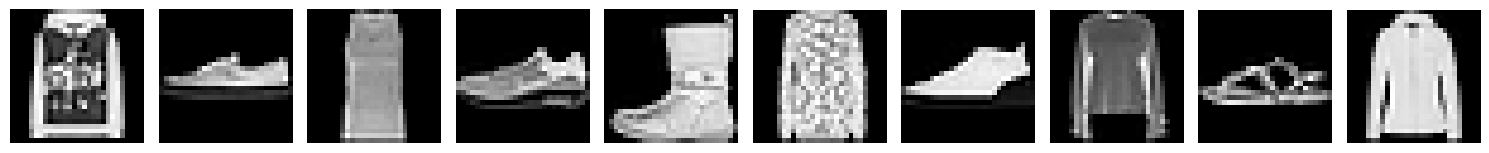

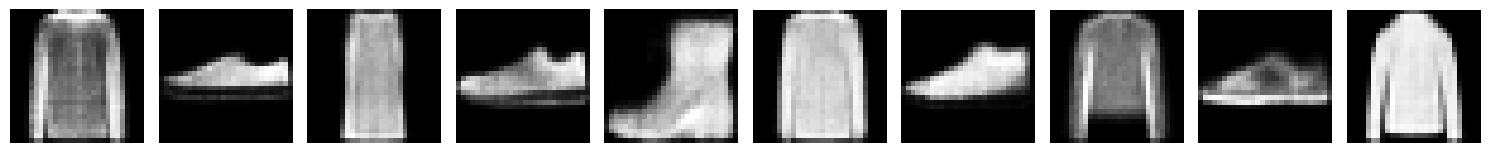

0.2783937871904012

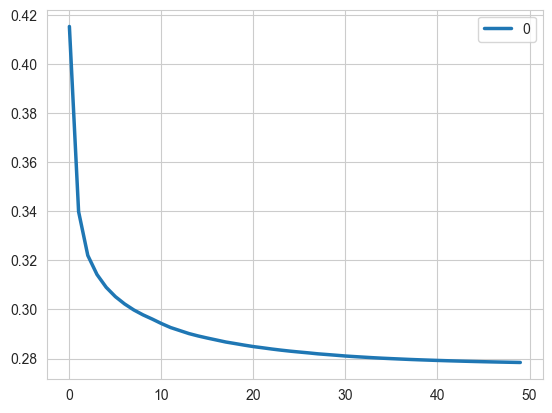

In [31]:
module1 = Linear(784, 264)
module2 = Linear(264, 88)
module3 = Linear(88, 30)
module4 = Linear(30, 88, weight=module3._parameters["w"].T)
module5 = Linear(88, 264, weight=module2._parameters["w"].T)
module6 = Linear(264, 784, weight=module1._parameters["w"].T)
act = LeakyReLU(0.01)

model = Sequential([
    module1, act,
    module2, act,
    module3, act,
    module4, act,
    module5, act,
    module6, Sigmoid()
])

loss = BCELoss()
eps_init = 1e-1
optim = Optim(model, loss=loss, eps=eps_init)

# Entraînement avec mini-batch et décroissance de eps
loss_train, loss_test = [], []
batch_size = 128
n_epochs = 50

for epoch in tqdm(range(n_epochs)):
    eps = eps_init * (0.95 ** epoch)
    epoch_loss = 0
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = X_train[indices]  # auto-encodeur => y = x

    for i in range(0, len(X_train), batch_size):
        xb = X_shuffled[i:i + batch_size]
        yb = y_shuffled[i:i + batch_size]
        lt, _ = optim.step(xb, yb, None, None, eps=eps)
        epoch_loss += lt * len(xb)

    loss_train.append(epoch_loss / len(X_train))

    # Calcul de la perte sur test
    lte, _ = optim.test(X_test, X_test)
    loss_test.append(lte)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {loss_train[-1]:.4f} - Test Loss: {loss_test[-1]:.4f}")
        
loss, pred = optim.test(X_test[:10], X_test[:10])
display_images(X_test[:10], ncols=10, figsize=(15, 6))
display_images(pred[:10], ncols=10, figsize=(15, 6))
df = pd.DataFrame(loss_train)
sns.lineplot(data=df, palette="tab10", linewidth=2.5)
display(loss_train[-1])

In [34]:
import pickle

df_loss = pd.DataFrame({
    'Train Loss':  loss_train,
    'Test Loss':   loss_test
})
csv_path = "models/loss2.csv"
df_loss.to_csv(csv_path, index=False)
print(f"Loss enregistrées dans : {csv_path}")

model_path = "models/model2.pkl"
with open(model_path, "wb") as f:
    pickle.dump(optim, f)
print(f"Modèle entraîné enregistré dans : {model_path}")

Loss enregistrées dans : models/loss2.csv
Modèle entraîné enregistré dans : models/model2.pkl


# Model 3 (model 6 de Louis) 

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:26<21:25, 26.24s/it]

Epoch 0 - Train Loss: 0.4105 - Test Loss: 0.3562


 22%|██▏       | 11/50 [04:52<17:11, 26.44s/it]

Epoch 10 - Train Loss: 0.2919 - Test Loss: 0.2938


 42%|████▏     | 21/50 [09:07<12:03, 24.93s/it]

Epoch 20 - Train Loss: 0.2828 - Test Loss: 0.2821


 62%|██████▏   | 31/50 [13:58<10:23, 32.82s/it]

Epoch 30 - Train Loss: 0.2784 - Test Loss: 0.2778


 82%|████████▏ | 41/50 [18:40<03:33, 23.76s/it]

Epoch 40 - Train Loss: 0.2759 - Test Loss: 0.2762


100%|██████████| 50/50 [22:43<00:00, 27.27s/it]


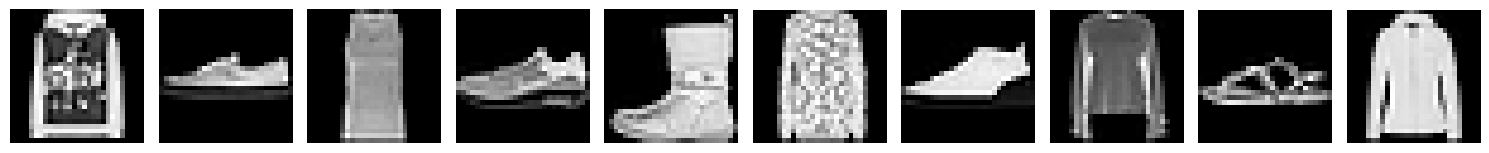

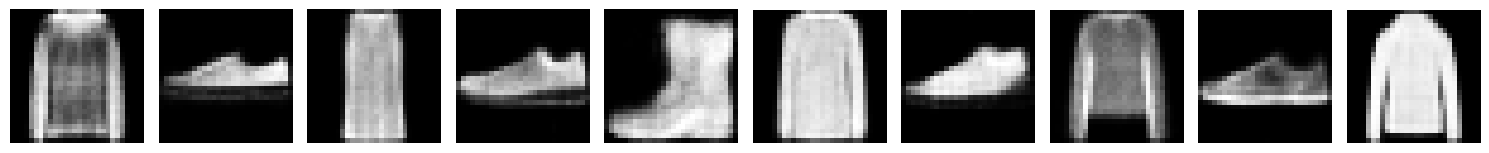

In [51]:
module1 = Linear(784, 424)
module2 = Linear(424, 128)
module3 = Linear(128, 32)
module4 = Linear(32, 128, weight=module4._parameters["w"].T)
module5 = Linear(128, 424, weight=module2._parameters["w"].T)
module6 = Linear(424, 784, weight=module1._parameters["w"].T)
act = LeakyReLU(0.01)
model = Sequential([
    module1, act,
    module2, act,
    module3, act,
    module4, act,
    module5, act,
    module6, Sigmoid()  # sortie finale [0,1] pour BCELoss
])
loss = BCELoss()
eps_init = 1e-1
optim = Optim(model, loss=loss, eps=eps_init)

# Entraînement avec mini-batch et décroissance de eps
loss_train, loss_test = [], []
batch_size = 128
n_epochs = 50

for epoch in tqdm(range(n_epochs)):
    eps = eps_init * (0.97 ** epoch)
    epoch_loss = 0
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = X_train[indices]  
    for i in range(0, len(X_train), batch_size):
        xb = X_shuffled[i:i + batch_size]
        yb = y_shuffled[i:i + batch_size]
        lt, _ = optim.step(xb, yb, None, None, eps=eps)
        epoch_loss += lt * len(xb)

    loss_train.append(epoch_loss / len(X_train))

    lte, _ = optim.test(X_test, X_test)
    loss_test.append(lte)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {loss_train[-1]:.4f} - Test Loss: {loss_test[-1]:.4f}")
        
loss, pred = optim.test(X_test[:10], X_test[:10])
display_images(X_test[:10], ncols=10, figsize=(15, 6))
display_images(pred[:10], ncols=10, figsize=(15, 6))
df = pd.DataFrame(loss_train)

In [53]:
import pickle

df_loss = pd.DataFrame({
    'Train Loss':  loss_train,
    'Test Loss':   loss_test
})
csv_path = "models/loss3.csv"
df_loss.to_csv(csv_path, index=False)
print(f"Loss enregistrées dans : {csv_path}")

model_path = "models/model3.pkl"
with open(model_path, "wb") as f:
    pickle.dump(optim, f)
print(f"Modèle entraîné enregistré dans : {model_path}")

Loss enregistrées dans : models/loss3.csv
Modèle entraîné enregistré dans : models/model3.pkl


# Model 4 (Model 8 de Louis)

In [47]:
module1 = Linear(784, 264)
module2 = Linear(264, 3)
module5 = Linear(3, 264, weight=module2._parameters["w"].T)
module6 = Linear(264, 784, weight=module1._parameters["w"].T)
act = LeakyReLU(0.01)

model = Sequential([
    module1, act,
    module2, act,
    module5, act,
    module6, Sigmoid()
])

loss = BCELoss()
eps_init = 1e-1
optim = Optim(model, loss=loss, eps=eps_init)

# Entraînement avec mini-batch et décroissance de eps
loss_train, loss_test = [], []
batch_size = 128
n_epochs = 50

for epoch in tqdm(range(n_epochs)):
    eps = eps_init * (0.97 ** epoch)
    epoch_loss = 0
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = X_train[indices]  # auto-encodeur => y = x

    for i in range(0, len(X_train), batch_size):
        xb = X_shuffled[i:i + batch_size]
        yb = y_shuffled[i:i + batch_size]
        lt, _ = optim.step(xb, yb, None, None, eps=eps)
        epoch_loss += lt * len(xb)

    loss_train.append(epoch_loss / len(X_train))

    # Calcul de la perte sur test
    lte, _ = optim.test(X_test, X_test)
    loss_test.append(lte)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {loss_train[-1]:.4f} - Test Loss: {loss_test[-1]:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:13<22:58, 13.92s/it]

Epoch 0 - Train Loss: 0.4118 - Test Loss: 0.3691


 11%|█         | 11/100 [03:46<36:56, 24.91s/it]

Epoch 10 - Train Loss: 0.3254 - Test Loss: 0.3258


 21%|██        | 21/100 [06:11<19:23, 14.72s/it]

Epoch 20 - Train Loss: 0.3195 - Test Loss: 0.3197


 31%|███       | 31/100 [08:29<16:16, 14.15s/it]

Epoch 30 - Train Loss: 0.3167 - Test Loss: 0.3158


 41%|████      | 41/100 [16:28<30:49, 31.35s/it]   

Epoch 40 - Train Loss: 0.3152 - Test Loss: 0.3138


 51%|█████     | 51/100 [34:40<2:54:35, 213.78s/it]

Epoch 50 - Train Loss: 0.3143 - Test Loss: 0.3131


 51%|█████     | 51/100 [34:45<33:23, 40.89s/it]   


KeyboardInterrupt: 

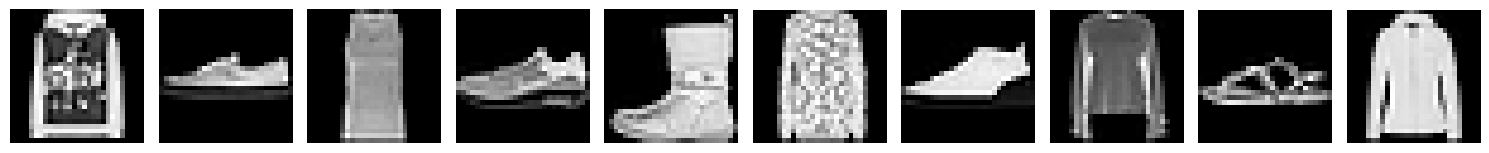

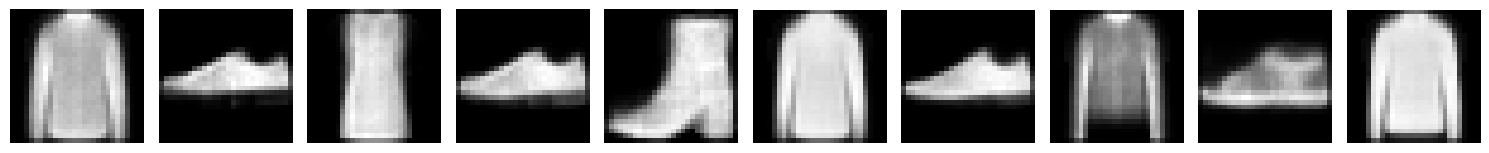

0.31434933221719885

Loss enregistrées dans : models/loss4.csv
Modèle entraîné enregistré dans : models/model4.pkl


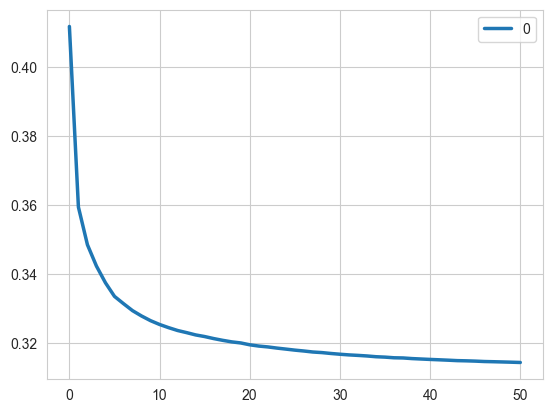

In [50]:
loss, pred = optim.test(X_test[:10], X_test[:10])
display_images(X_test[:10], ncols=10, figsize=(15, 6))
display_images(pred[:10], ncols=10, figsize=(15, 6))
df = pd.DataFrame(loss_train)
sns.lineplot(data=df, palette="tab10", linewidth=2.5)
display(loss_train[-1])

import pickle

df_loss = pd.DataFrame({
    'Train Loss':  loss_train,
    'Test Loss':   loss_test
})
csv_path = "models/loss4.csv"
df_loss.to_csv(csv_path, index=False)
print(f"Loss enregistrées dans : {csv_path}")

model_path = "models/model4.pkl"
with open(model_path, "wb") as f:
    pickle.dump(optim, f)
print(f"Modèle entraîné enregistré dans : {model_path}")